# The Bias-Variance Tradeoff
<<<< Include technical notes here >>>>

# Imports

In [5]:
import sys
sys.path.append('../src/utils/')

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from plotting import clean_ax

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge

plt.style.use('dark_background')

# Generate data
Here we will generate 100 datasets, each containing $N=25$ data points, independently from the sinusoidal curve $h(x)=\sin(2\pi x)$. the data sets are indexed by $l=1, \dots, L$, where $L=100$, and for each dataset $\mathcal{D}^{(l)}$ we fit a model with $24$ Gaussian basis functions by minimizing the regularized error function:
$$\dfrac{1}{2}\sum_{n=1}^{N}\left\{t_n - \mathbf{w}^T \phi(\mathbf{x}_n)\right\}^2 + \dfrac{\lambda}{2}\mathbf{w}^T\mathbf{w},$$
to give a prediction function $y^{(l)}(x)$.

The Gaussian basis functions are not implemented in sklearn. A very simple implementation can be found in  [this](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html) blog post, from which we borrow the following class:

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

The following two auxiliary functions will generate actual data from a sinusoidal function

In [37]:
def func(x):
    """wrapper for a simple a sine function"""
    return np.sin(2* np.pi * x)

def get_X_y(low:float = 0, high:float = 1, sample_size: int = 25):
    """Produces the X and y sample, given the uniform 
    distribution parameters and the sample size
    Parameters
    ----------
    low: float (default = 0.0)
        Beta `a` parameter, must be >0
    high: float (default = 1.0)
        Beta `b` parameters, must be >0
    sample_size: int (deafult = 50)
        size of the sample to be generated

    Returns
    -------
    X: list[float]
        Covariate samples
    y: list[float]
        Response variable samples
    """
    X = np.random.uniform(low, high, sample_size) 
    y = func(X) + np.random.normal(0, 0.2, size = sample_size)
    return X, y

# Bias-variance example from Bishop

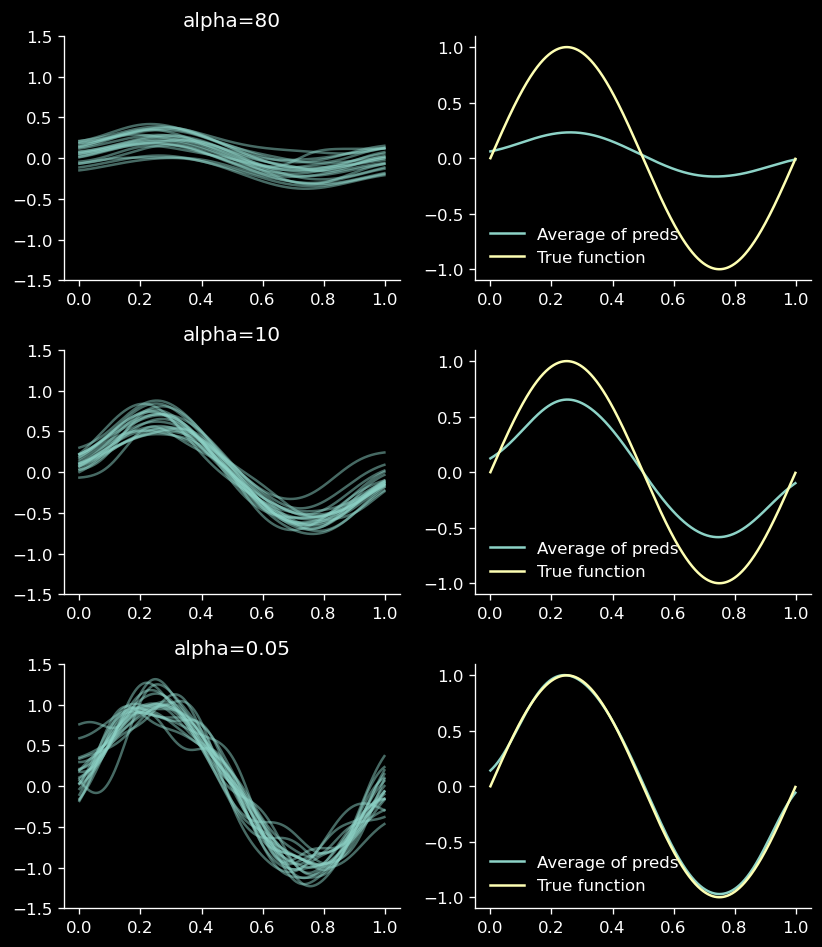

In [139]:
L = 20

X_test = np.arange(0,1,1e-3)

f, ax = plt.subplots(3, 2, dpi=120, figsize=(7,8)) 
for axis, alpha in zip(ax, [80, 10, 0.05]):
    y_preds = []
    for l in np.arange(0,L,1):
        X, y = get_X_y()
        model = make_pipeline(
            GaussianFeatures(24),
            Ridge(alpha=alpha)
            )
        model.fit(X[:, np.newaxis],y)
        y_pred = model.predict(X_test[:, np.newaxis])
        y_preds.append(np.array(y_pred))
        axis[0].plot(X_test, y_pred, alpha=0.5, c='C0')
        clean_ax(axis[0])
        axis[0].set_ylim(-1.5,1.5)
    axis[0].set_title(f'alpha={alpha}')
    axis[1].plot(X_test, np.mean(y_preds, axis=0), c='C0', label='Average of preds')
    axis[1].plot(X_test, func(X_test), c='C1', label='True function')
    axis[1].legend(loc='best', frameon=False)
    clean_ax(axis[1])
f.tight_layout()
plt.show()

The top row corresponds to a large value of regularization coefficient $\alpha$ that gives low variance and high bias. Conversely, the bottom row corresponds to a small value of regularization coefficient $\alpha$ which gives high variance and low bias.